In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

In [75]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, mean_squared_error
from sklearn.decomposition import PCA

# EDA yeast

## Información del dataset yeast

In [84]:
nombres = open('yeast.names','r')
print(nombres.read())

1. Title: Protein Localization Sites


2. Creator and Maintainer:
	     Kenta Nakai
             Institue of Molecular and Cellular Biology
	     Osaka, University
	     1-3 Yamada-oka, Suita 565 Japan
	     nakai@imcb.osaka-u.ac.jp
             http://www.imcb.osaka-u.ac.jp/nakai/psort.html
   Donor: Paul Horton (paulh@cs.berkeley.edu)
   Date:  September, 1996
   See also: ecoli database

3. Past Usage.
Reference: "A Probablistic Classification System for Predicting the Cellular 
           Localization Sites of Proteins", Paul Horton & Kenta Nakai,
           Intelligent Systems in Molecular Biology, 109-115.
	   St. Louis, USA 1996.
Results: 55% for Yeast data with an ad hoc structured
	 probability model. Also similar accuracy for Binary Decision Tree and
	 Bayesian Classifier methods applied by the same authors in
	 unpublished results.

Predicted Attribute: Localization site of protein. ( non-numeric ).


4. The references below describe a predecessor to this dataset and its 
de

In [86]:
nombres_columnas = ['Secuencia','mcg','gvh','alm','mit','erl','pox','vac','nuc','Class']
data = pd.read_csv('yeast.data',names = nombres_columnas, sep='\s+')
print(data)

       Secuencia   mcg   gvh   alm   mit  erl  pox   vac   nuc Class
0     ADT1_YEAST  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22   MIT
1     ADT2_YEAST  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22   MIT
2     ADT3_YEAST  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22   MIT
3     AAR2_YEAST  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22   NUC
4     AATM_YEAST  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22   MIT
...          ...   ...   ...   ...   ...  ...  ...   ...   ...   ...
1479  YUR1_YEAST  0.81  0.62  0.43  0.17  0.5  0.0  0.53  0.22   ME2
1480  ZIP1_YEAST  0.47  0.43  0.61  0.40  0.5  0.0  0.48  0.47   NUC
1481  ZNRP_YEAST  0.67  0.57  0.36  0.19  0.5  0.0  0.56  0.22   ME2
1482  ZUO1_YEAST  0.43  0.40  0.60  0.16  0.5  0.0  0.53  0.39   NUC
1483  G6PD_YEAST  0.65  0.54  0.54  0.13  0.5  0.0  0.53  0.22   CYT

[1484 rows x 10 columns]


## Balance de clases

In [5]:
clases = ['CYT','NUC','MIT','ME3','ME2','ME1','EXC','VAC','POX','ERL']
proporcion_aparicion = []
for string in clases:
    proporcion_aparicion.append(len(data.loc[(data['Class']==string)])*100/len(data))

proporcion_aparicion = pd.DataFrame(proporcion_aparicion, index = clases, columns=['Balance de clases (%)'])
display(proporcion_aparicion)

,Balance de clases (%)
CYT,31.199461
NUC,28.908356
MIT,16.442049
ME3,10.983827
ME2,3.436658
ME1,2.964960
EXC,2.358491
VAC,2.021563
POX,1.347709
ERL,0.336927


## Análisis de media y varianza

Se comienza graficando el boxplot de cada variable de entrada, discriminando por clases

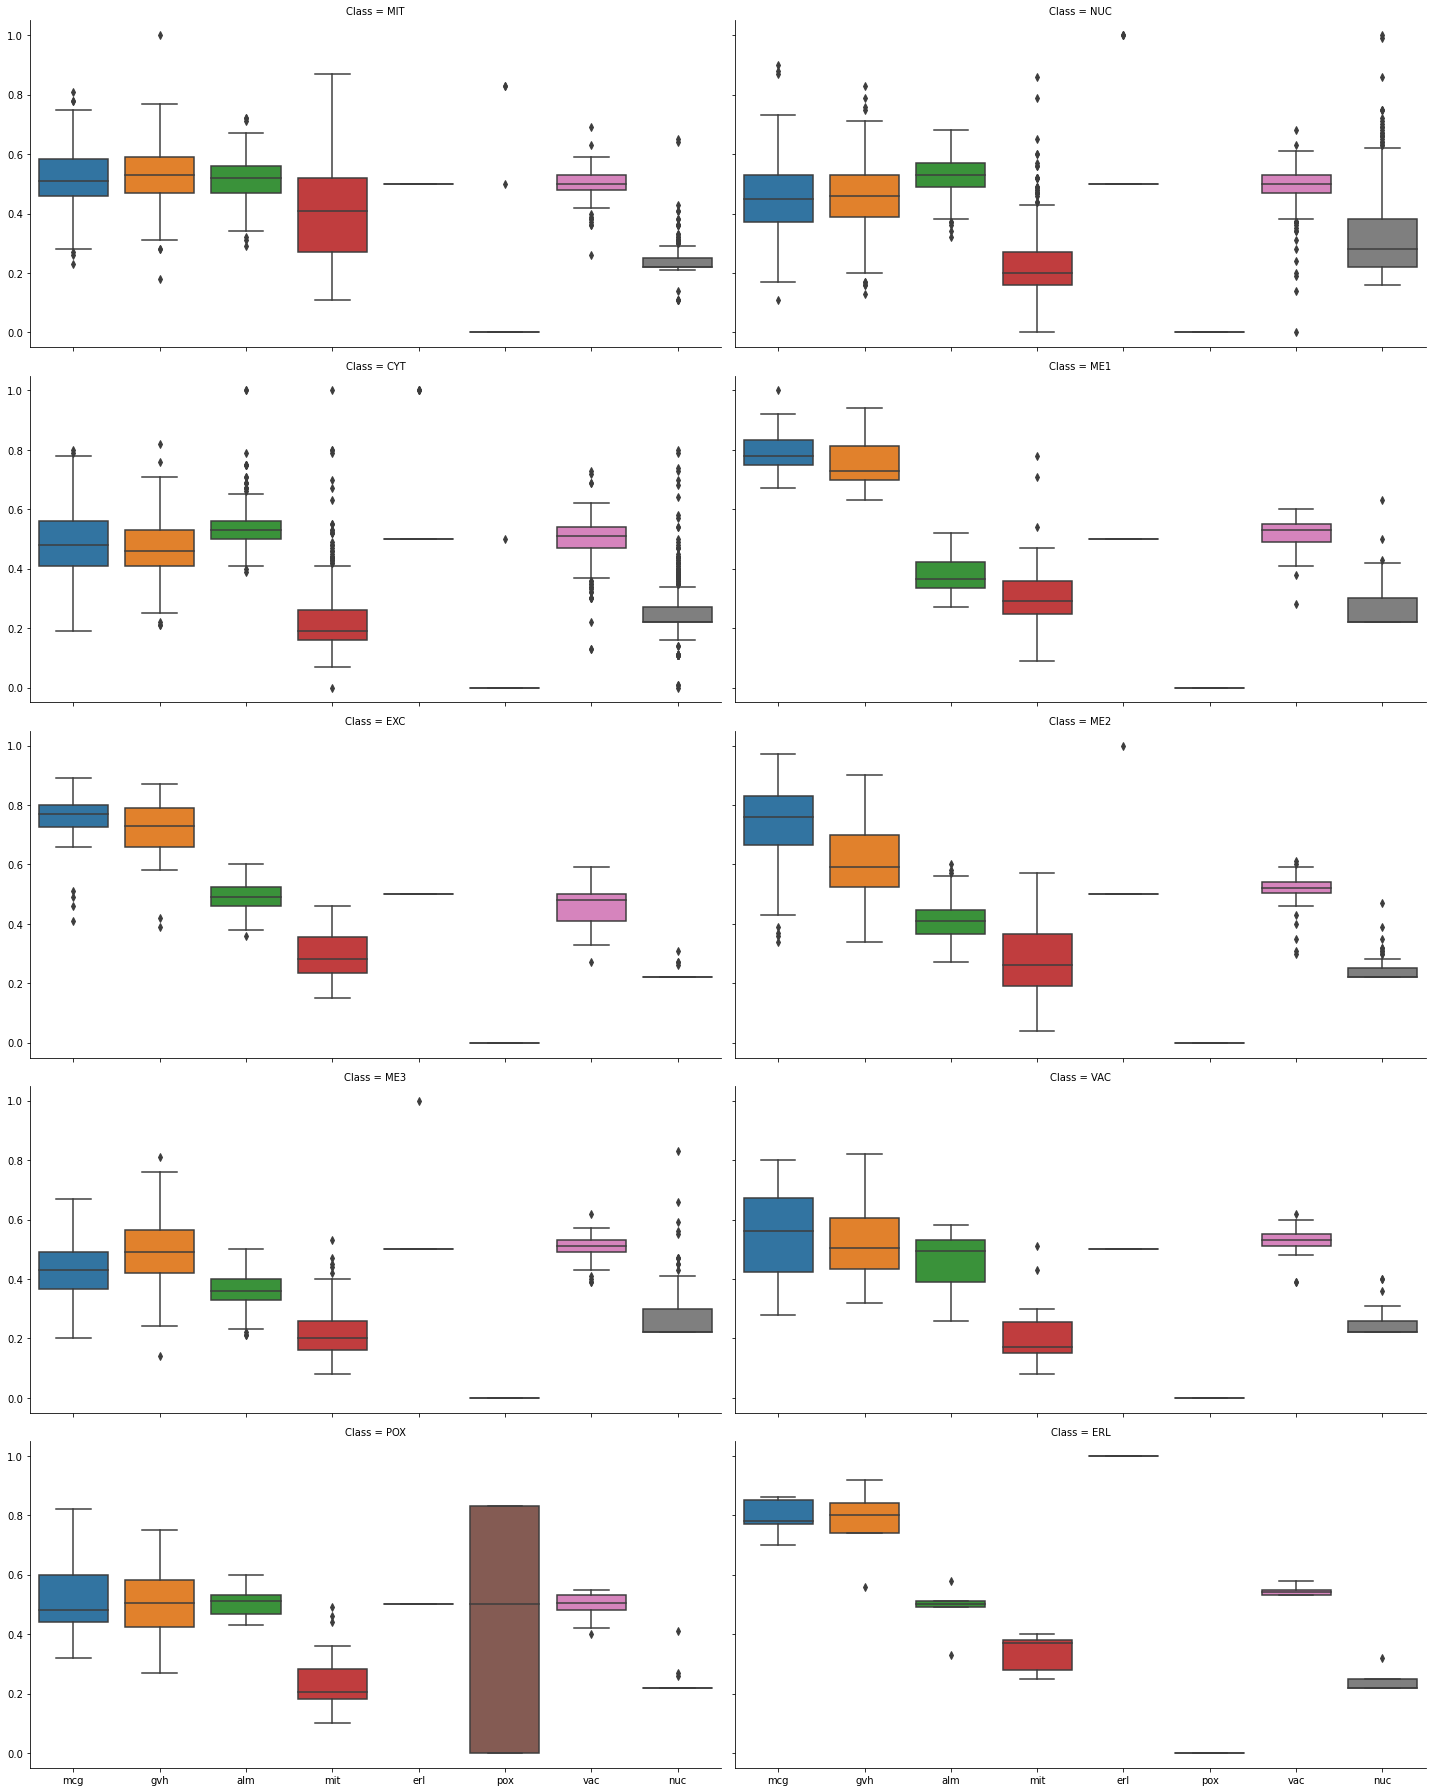

In [6]:
#Guardo cada columna en una variable distinta
secuencia = data['Secuencia']
mcg = data['mcg']
gvh = data['gvh']
alm = data['alm']
mit = data['mit']
erl = data['erl']
pox = data['pox']
vac = data['vac']
nuc = data['nuc']
clase = data['Class']

parametros= [mcg,gvh,alm,mit,erl,pox,vac,nuc]

sns.catplot(data=data,kind='box', aspect = 2, col_wrap = 2, col='Class')

Se observa que, en general, las variables tienen diferente media y varianza si se discrimina entre clases. Se obtiene a continuación un vector de medias y varianzas de las variables para cada clase:

In [87]:
clases = ['CYT','NUC','MIT','ME3','ME2','ME1','EXC','VAC','POX','ERL']
medias=[]
varianzas=[]

data_aux = data.drop('Class', axis=1).drop('Secuencia', axis=1) #Dataframe con los datos solo que sin la columna 'Class' ni 'Secuencia'
medias.append(data_aux.mean(axis=0)) #Saco la media global de cada variable
varianzas.append(data_aux.var(axis=0)) #Saco la varianza global de cada variable

for i in range(len(clases)):
    array = data.loc[(data['Class']==clases[i])].drop('Class',axis=1).drop('Secuencia',axis=1) #Filtro por clase y saco las columnas 'Class' y 'Secuencia' para quedarme solo con números
    medias.append(array.mean(axis=0))
    varianzas.append(array.var(axis=0))

#Paso las medias y varianzas a DataFrame
medias=pd.DataFrame(medias, index=['Global'] + clases)
varianzas=pd.DataFrame(varianzas, index=['Global'] + clases)

#Se puede acceder a los vectores de media de cada variable y clase (o valores individuales) con "medias['mcg']", por ejemplo

print('\t Media de las variables, global y discriminando por clases:')
display(medias)
print('\t Varianza de las variables, global y discriminando por clases:')
display(varianzas)

	 Media de las variables, global y discriminando por clases:


,mcg,gvh,alm,mit,erl,pox,vac,nuc
Global,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
CYT,0.480713,0.469503,0.535421,0.227106,0.504320,0.001080,0.499395,0.257235
NUC,0.452448,0.456131,0.529324,0.228345,0.503497,0.000000,0.494103,0.331678
MIT,0.521434,0.533238,0.517377,0.404426,0.500000,0.008852,0.501680,0.240984
ME3,0.430859,0.489509,0.364294,0.213497,0.503067,0.000000,0.510123,0.270000
ME2,0.721569,0.603137,0.414902,0.282549,0.509804,0.000000,0.510196,0.245490
ME1,0.788636,0.756591,0.376136,0.311818,0.500000,0.000000,0.512955,0.268182
EXC,0.735429,0.716857,0.492571,0.292000,0.500000,0.000000,0.455714,0.226571
VAC,0.547667,0.526000,0.465333,0.201000,0.500000,0.000000,0.525000,0.250667
POX,0.521000,0.508000,0.506500,0.247500,0.500000,0.423500,0.503000,0.234000


	 Varianza de las variables, global y discriminando por clases:


,mcg,gvh,alm,mit,erl,pox,vac,nuc
Global,0.018851,0.015357,0.007512,0.018796,0.002338,0.005728,0.003340,0.011340
CYT,0.011544,0.008485,0.004186,0.013263,0.002146,0.000540,0.004100,0.009007
NUC,0.012306,0.012087,0.003403,0.012077,0.001740,0.000000,0.003680,0.018517
MIT,0.009455,0.009705,0.005318,0.027506,0.000000,0.006620,0.002163,0.003247
ME3,0.009781,0.013050,0.002953,0.006430,0.001534,0.000000,0.001244,0.008251
ME2,0.025717,0.014494,0.005705,0.015743,0.004902,0.000000,0.003686,0.002673
ME1,0.004505,0.005372,0.003564,0.016206,0.000000,0.000000,0.003714,0.007987
EXC,0.012231,0.011552,0.002984,0.005022,0.000000,0.000000,0.004913,0.000388
VAC,0.019936,0.017983,0.008474,0.008878,0.000000,0.000000,0.002433,0.002703
POX,0.017736,0.012891,0.002582,0.012346,0.000000,0.163845,0.001622,0.001909


## Análisis de correlación

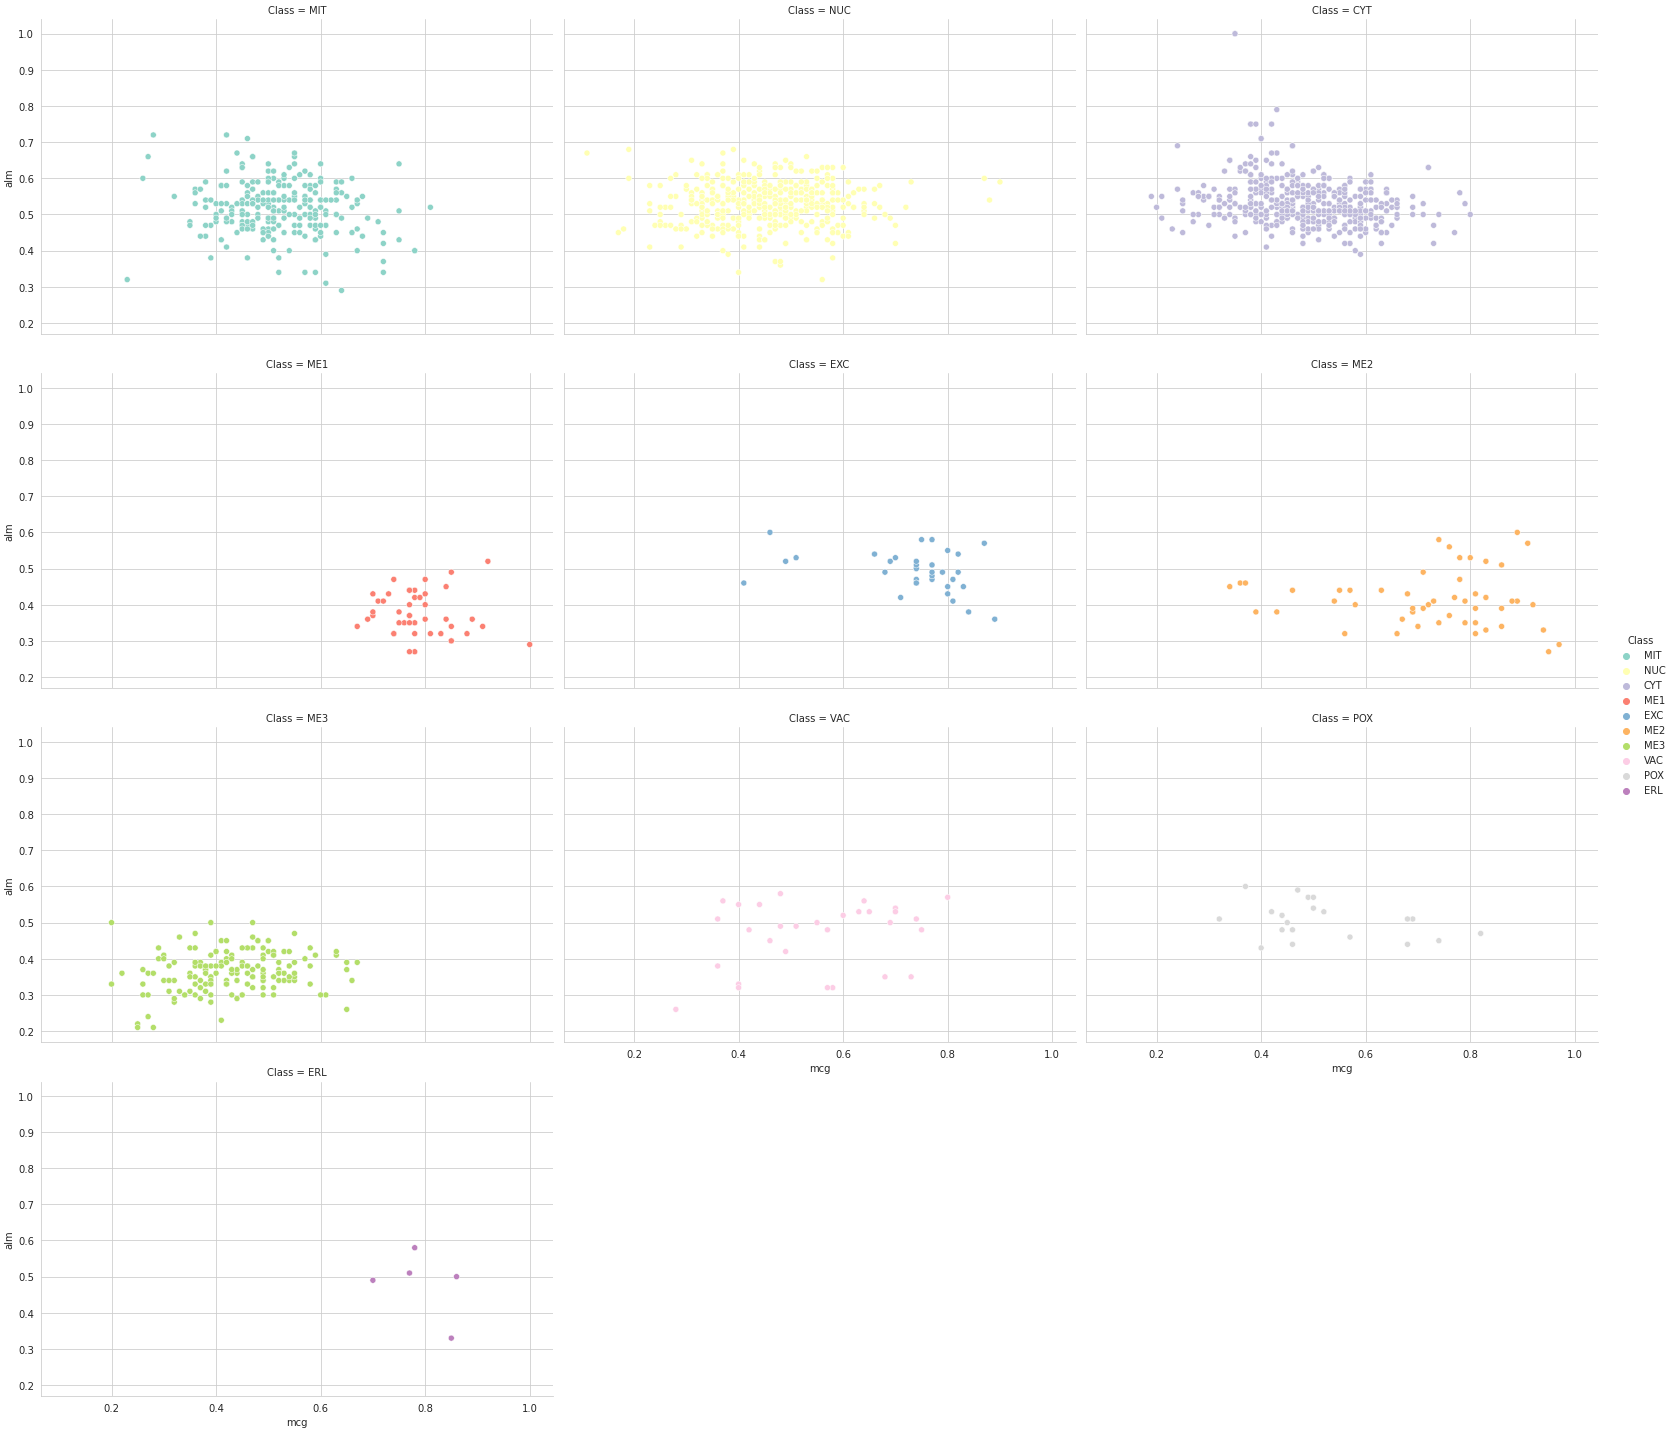

In [8]:
#Gráficos de correlación
with sns.axes_style('whitegrid'):
    sns.relplot(data=data, x='mcg', y='alm', hue = 'Class', col_wrap = 3, col = 'Class', palette = 'Set3', aspect = 1.5)

Cambiando las variables que se grafican, se puede ver que a simple vista no hay correlaciones muy marcadas. Calculo la matriz de correlación sin discriminar y discriminando por clases:

In [9]:
#Sin discriminar entre clases
df_corr = data.drop('Class',axis=1).drop('Secuencia',axis=1) #Saco las columnas 'Class' y 'Secuencia' para quedarme solo con números

matriz_corr = np.corrcoef(df_corr, rowvar=False)

etiquetas = ['mcg','gvh','alm','mit','erl','pox','vac','nuc']
matriz_corr = pd.DataFrame(matriz_corr, index=etiquetas, columns=etiquetas) #Lo convierto en DataFrame
print('\t Matriz de correlación entre las variables, sin discriminar entre clases:')
display(matriz_corr)

#Discriminando entre clases
with np.errstate(divide='ignore',invalid='ignore'):
    clases = ['CYT','NUC','MIT','ME3','ME2','ME1','EXC','VAC','POX','ERL']
    for clase in clases:
        df_aux = data.loc[(data['Class']==clase)].drop('Class',axis=1).drop('Secuencia',axis=1) #Filtro por clase y saco las columnas 'Class' y 'Secuencia' para quedarme solo con números
        matriz_corr_clases = np.corrcoef(df_aux, rowvar=False)
        matriz_corr_clases = pd.DataFrame(matriz_corr_clases, index=etiquetas, columns=etiquetas) #Lo convierto en DataFrame
        print('\t Matriz de correlación entre las variables, para la clase:', clase)
        display(matriz_corr_clases)

	 Matriz de correlación entre las variables, sin discriminar entre clases:


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,0.581631,-0.163951,0.158175,0.064922,0.005597,0.075043,-0.124540
gvh,0.581631,1.000000,-0.271800,0.140314,0.060823,0.000392,0.088759,-0.102984
alm,-0.163951,-0.271800,1.000000,0.059668,-0.008083,0.009378,-0.185805,-0.022043
mit,0.158175,0.140314,0.059668,1.000000,-0.005931,-0.009040,-0.103591,-0.054797
erl,0.064922,0.060823,-0.008083,-0.005931,1.000000,-0.009674,0.043627,0.002829
pox,0.005597,0.000392,0.009378,-0.009040,-0.009674,1.000000,0.020900,-0.035659
vac,0.075043,0.088759,-0.185805,-0.103591,0.043627,0.020900,1.000000,0.089690
nuc,-0.124540,-0.102984,-0.022043,-0.054797,0.002829,-0.035659,0.089690,1.000000


	 Matriz de correlación entre las variables, para la clase: CYT


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,0.369618,-0.235666,-0.022276,-0.035412,0.012696,0.111948,-0.028844
gvh,0.369618,1.000000,-0.288193,-0.155855,-0.019786,-0.035142,0.280512,0.008954
alm,-0.235666,-0.288193,1.000000,0.271154,-0.047550,0.017693,-0.378212,-0.213697
mit,-0.022276,-0.155855,0.271154,1.000000,0.028721,-0.023094,-0.304578,-0.148901
erl,-0.035412,-0.019786,-0.047550,0.028721,1.000000,-0.004343,0.015478,0.015031
pox,0.012696,-0.035142,0.017693,-0.023094,-0.004343,1.000000,-0.006834,-0.018273
vac,0.111948,0.280512,-0.378212,-0.304578,0.015478,-0.006834,1.000000,0.180705
nuc,-0.028844,0.008954,-0.213697,-0.148901,0.015031,-0.018273,0.180705,1.000000


	 Matriz de correlación entre las variables, para la clase: NUC


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,0.376721,0.012280,0.062620,0.056211,NaN,0.074919,-0.108881
gvh,0.376721,1.000000,-0.143260,0.010414,0.008052,NaN,0.031356,-0.059238
alm,0.012280,-0.143260,1.000000,-0.043256,0.029780,NaN,-0.104591,-0.093843
mit,0.062620,0.010414,-0.043256,1.000000,-0.036960,NaN,0.011464,0.024621
erl,0.056211,0.008052,0.029780,-0.036960,1.000000,NaN,0.045098,0.025718
pox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vac,0.074919,0.031356,-0.104591,0.011464,0.045098,NaN,1.000000,0.119931
nuc,-0.108881,-0.059238,-0.093843,0.024621,0.025718,NaN,0.119931,1.000000


	 Matriz de correlación entre las variables, para la clase: MIT


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,0.369266,-0.178500,-0.052171,NaN,0.087282,0.139510,-0.001444
gvh,0.369266,1.000000,-0.376295,0.069165,NaN,0.023671,0.047399,0.025969
alm,-0.178500,-0.376295,1.000000,-0.039934,NaN,-0.029500,-0.112506,-0.043051
mit,-0.052171,0.069165,-0.039934,1.000000,NaN,-0.008009,-0.058321,0.189530
erl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pox,0.087282,0.023671,-0.029500,-0.008009,NaN,1.000000,0.019543,-0.025497
vac,0.139510,0.047399,-0.112506,-0.058321,NaN,0.019543,1.000000,0.015679
nuc,-0.001444,0.025969,-0.043051,0.189530,NaN,-0.025497,0.015679,1.000000


	 Matriz de correlación entre las variables, para la clase: ME3


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,0.350917,0.193306,0.168680,0.071035,NaN,0.113739,0.023844
gvh,0.350917,1.000000,0.129408,0.044729,0.041731,NaN,0.000321,0.004045
alm,0.193306,0.129408,1.000000,-0.013808,0.037279,NaN,0.037720,0.158697
mit,0.168680,0.044729,-0.013808,1.000000,-0.121372,NaN,-0.002989,0.282294
erl,0.071035,0.041731,0.037279,-0.121372,1.000000,NaN,0.089088,-0.017353
pox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vac,0.113739,0.000321,0.037720,-0.002989,0.089088,NaN,1.000000,-0.045079
nuc,0.023844,0.004045,0.158697,0.282294,-0.017353,NaN,-0.045079,1.000000


	 Matriz de correlación entre las variables, para la clase: ME2


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,0.574359,-0.049520,0.438827,-0.232963,NaN,-0.088362,0.008107
gvh,0.574359,1.000000,0.058976,0.528530,-0.157951,NaN,-0.066030,-0.116564
alm,-0.049520,0.058976,1.000000,0.101636,0.047458,NaN,0.085702,0.235711
mit,0.438827,0.528530,0.101636,1.000000,-0.116734,NaN,-0.099834,0.100152
erl,-0.232963,-0.157951,0.047458,-0.116734,1.000000,NaN,-0.118089,-0.070415
pox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vac,-0.088362,-0.066030,0.085702,-0.099834,-0.118089,NaN,1.000000,-0.177475
nuc,0.008107,-0.116564,0.235711,0.100152,-0.070415,NaN,-0.177475,1.000000


	 Matriz de correlación entre las variables, para la clase: ME1


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,0.214601,-0.101754,0.270836,NaN,NaN,-0.084838,0.291117
gvh,0.214601,1.000000,-0.186452,0.137518,NaN,NaN,-0.192930,0.059032
alm,-0.101754,-0.186452,1.000000,-0.132781,NaN,NaN,-0.108649,-0.315622
mit,0.270836,0.137518,-0.132781,1.000000,NaN,NaN,-0.181756,0.596142
erl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vac,-0.084838,-0.192930,-0.108649,-0.181756,NaN,NaN,1.000000,0.200828
nuc,0.291117,0.059032,-0.315622,0.596142,NaN,NaN,0.200828,1.000000


	 Matriz de correlación entre las variables, para la clase: EXC


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,0.744278,-0.328052,0.364450,NaN,NaN,0.040649,0.062807
gvh,0.744278,1.000000,-0.189937,0.229831,NaN,NaN,-0.058448,0.185113
alm,-0.328052,-0.189937,1.000000,-0.088733,NaN,NaN,-0.102263,-0.106376
mit,0.364450,0.229831,-0.088733,1.000000,NaN,NaN,-0.111902,-0.049730
erl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vac,0.040649,-0.058448,-0.102263,-0.111902,NaN,NaN,1.000000,0.121131
nuc,0.062807,0.185113,-0.106376,-0.049730,NaN,NaN,0.121131,1.000000


	 Matriz de correlación entre las variables, para la clase: VAC


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,0.682245,0.268415,0.248487,NaN,NaN,0.544417,0.165570
gvh,0.682245,1.000000,0.151510,0.209914,NaN,NaN,0.288819,0.150750
alm,0.268415,0.151510,1.000000,0.208873,NaN,NaN,0.226321,-0.025986
mit,0.248487,0.209914,0.208873,1.000000,NaN,NaN,0.044147,0.177948
erl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vac,0.544417,0.288819,0.226321,0.044147,NaN,NaN,1.000000,0.141195
nuc,0.165570,0.150750,-0.025986,0.177948,NaN,NaN,0.141195,1.000000


	 Matriz de correlación entre las variables, para la clase: POX


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,0.498598,-0.342456,0.154898,NaN,-0.302053,-0.044745,0.109614
gvh,0.498598,1.000000,-0.227532,0.017105,NaN,-0.149980,-0.056168,0.007002
alm,-0.342456,-0.227532,1.000000,-0.338162,NaN,0.029543,0.005401,-0.280183
mit,0.154898,0.017105,-0.338162,1.000000,NaN,-0.305104,-0.293436,0.122491
erl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pox,-0.302053,-0.149980,0.029543,-0.305104,NaN,1.000000,0.297951,0.190795
vac,-0.044745,-0.056168,0.005401,-0.293436,NaN,0.297951,1.000000,-0.031102
nuc,0.109614,0.007002,-0.280183,0.122491,NaN,0.190795,-0.031102,1.000000


	 Matriz de correlación entre las variables, para la clase: ERL


,mcg,gvh,alm,mit,erl,pox,vac,nuc
mcg,1.000000,-0.246479,-0.420693,0.554117,NaN,NaN,-0.675263,0.753538
gvh,-0.246479,1.000000,0.663898,-0.098793,NaN,NaN,-0.049881,0.359535
alm,-0.420693,0.663898,1.000000,-0.537097,NaN,NaN,-0.309155,-0.172913
mit,0.554117,-0.098793,-0.537097,1.000000,NaN,NaN,-0.231854,0.408885
erl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vac,-0.675263,-0.049881,-0.309155,-0.231854,NaN,NaN,1.000000,-0.411518
nuc,0.753538,0.359535,-0.172913,0.408885,NaN,NaN,-0.411518,1.000000


Sin discriminar entre clases, solo parece haber una correlación apreciable entre mcg y gvh, entre algunas otras correlaciones muy leves ([mcg,alm], [mcg,mit], [mcg,nuc], [gvh,alm], [gvh,mit], [gvh,nuc], [alm,vac], [mit,vac]). Por otro lado, en algunas clases las correlaciones se dan de forma mas pronunciada, como es el caso de los pares [mcg,gvh], [mcg,mit], [mcg,erl], [gvh,mit], [alm,nuc] para la clase 'ME2'. Sin embargo, al tratarse de una clase de poco peso en el balance de clase (apenas 3.43%), tiene poca influencia en la correlación global.

Nota: Los valores NaN cuando se discrimina entre clases se deben a que no habia observaciones de las variables 'erl' y 'pox' para algunas clases.

## Análisis de distribución de los datos

<AxesSubplot:xlabel='vac', ylabel='Count'>

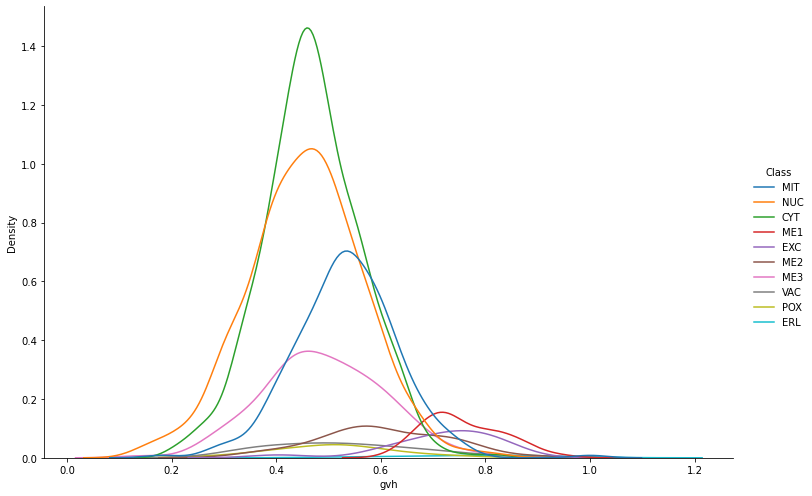

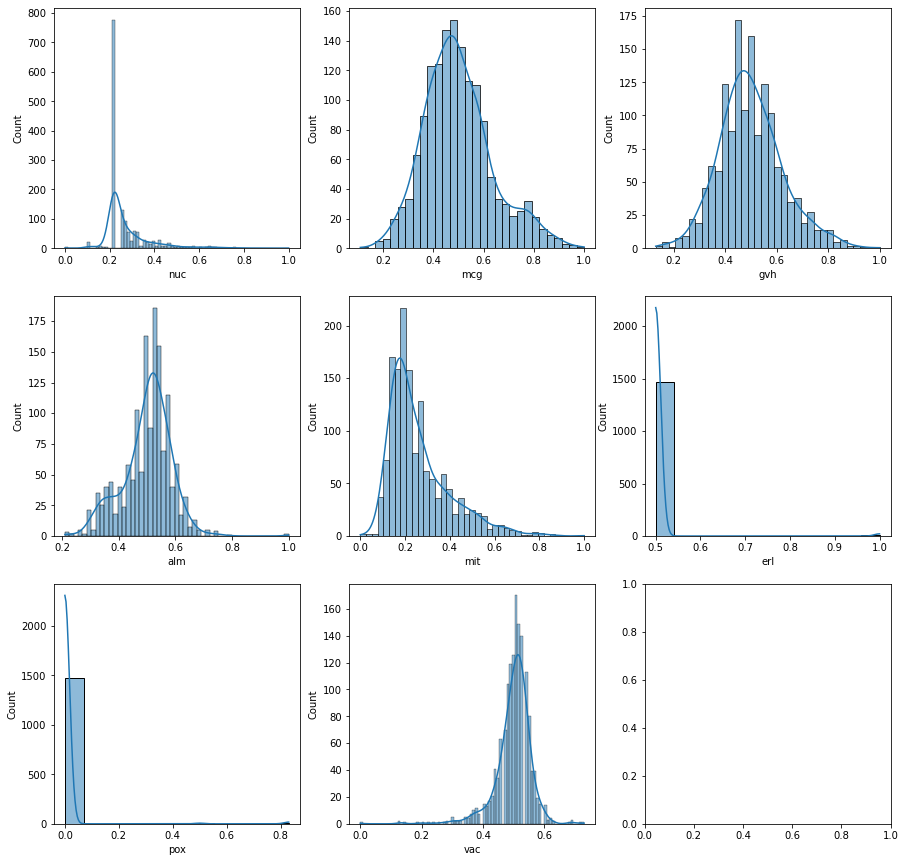

In [88]:
#Distintas formas de mostrar KDE para una variable particular, discriminando por clases
sns.displot(data=data, x = 'gvh', kind='kde', height = 7, aspect = 1.5, hue='Class')

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize=(15,15))

sns.histplot(x=nuc, kde=True, ax=ax1)
sns.histplot(x=mcg, kde=True, ax=ax2)
sns.histplot(x=gvh, kde=True, ax=ax3)
sns.histplot(x=alm, kde=True, ax=ax4)
sns.histplot(x=mit, kde=True, ax=ax5)
sns.histplot(x=erl, kde=True, ax=ax6)
sns.histplot(x=pox, kde=True, ax=ax7)
sns.histplot(x=vac, kde=True, ax=ax8)


Cambiando la variable que se grafica en el primer gráfico, se ve que si se discrimina entre clases, en general la curva de densidad de las variables se aproxima a la de una gaussiana. Sin embargo en el segundo gráfico (sin discriminar entre clases), se ve que las variables nuc, erl y pox no tienen una distribución gaussiana, mientras que el resto puede aproximarse a una (o quizás suma de gaussianas, siendo mas apropiado para mcg, alm y mit debido a esos pequeños lobulos o asimetrías que aparecen).

En general el valor medio de las variables no cambia significativamente si se discrimina por clases, o se presentan multiples clases con valores medios similares.

Por otro lado, se puede ver que las variables 'erl' y 'pox' son categóricas (erl en particular es binaria), y que la distribución de las mismas se encuentra ampliamente inclinada hacia un valor:

In [11]:
print('Proporción de datos en la variable "erl":\n', data.erl.value_counts())

print('\nProporción de datos en la variable "pox":\n', data.pox.value_counts())

Proporción de datos en la variable "erl":
 0.5    1470
1.0      14
Name: erl, dtype: int64

Proporción de datos en la variable "pox":
 0.00    1469
0.83      11
0.50       4
Name: pox, dtype: int64


## Conclusiones del EDA

Las variables presentan en general distribuciones que se asemejan a la normal, siendo esta semejanza a veces un poco débil para algunas variables. Comparando las variables de manera "todo contra todo", se puede ver que no hay correlación fuerte entre ninguna de ellas. Tan solo se presentan algunas correlaciones significativas en clases especificas, pero esto no tiene influencia globalmente.

Para el problema de clasificación, se usarán todas las variables excepto 'erl' y 'pox' debido a que estas son categoricas, además de que la proporción de valores en las mismas se encuentra mal distribuido, lo que podría perjudicar la clasificación.

Por otra parte, dado que el balance de clases indica que las clases 'CYT', 'NUC', 'MIT' y 'ME3' cuentan el 87% de las observaciones, se utilizan esas 4 clases para el problema de clasificación multiclase.

# Clasificador yeast

Realizaré la clasificación con distintos modelos (de la librería sklearn), y elegiré el que dé los mejores resultados. Primero obtengo el set de entrenamiento y testeo, para lo cual normalizo las variables de entrada:

In [12]:
#Normalizo los datos de entrada

data_normalizada = data.drop(columns=['Secuencia','erl','pox']) #Saco la columna Secuencia.  Erl y pox también, por lo mencionado en las conclusiones del EDA)

for j in range(np.shape(data_normalizada)[1]):
    if type(data_normalizada.iloc[1,j]) != str:
        media = np.mean(data_normalizada.iloc[:,j])
        var = np.var(data_normalizada.iloc[:,j])
        data_normalizada.iloc[:,j] = (data_normalizada.iloc[:,j] - media)/(np.sqrt(var))

#Data_normalizada es ahora el dataset normalizado, sin las columnas Secuencia, erl y pox, con todas las clases.

data_filt_4clases = data_normalizada[data_normalizada['Class'].isin(['CYT', 'NUC', 'MIT', 'ME3'])]  #Me quedo con las clases que me interesan

X = data_filt_4clases.drop(columns='Class').values      #Datos de entrada, normalizados y correspondientes a las 4 clases CYT, NUC, MIT, ME3
Y = data_filt_4clases.Class.values                      #Output

x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state = 0, test_size=0.3, stratify=data_filt_4clases['Class'])

El balance de clases para este dataset filtrado queda:

In [129]:
clases_rep = ['CYT','NUC','MIT','ME3']
proporcion_aparicion_rep = []
for string in clases_rep:
    proporcion_aparicion_rep.append(len(data_filt_4clases.loc[(data_filt_4clases['Class']==string)])*100/len(data_filt_4clases))

proporcion_aparicion_rep = pd.DataFrame(proporcion_aparicion_rep, index = clases_rep, columns=['Balance de clases (%)'])
display(proporcion_aparicion_rep)

,Balance de clases (%)
CYT,35.642802
NUC,33.025404
MIT,18.783680
ME3,12.548114


Dado que el balance de clases no está bien distribuido, la métrica de evaluación que se utilizará es el F1-score. Si bien la exactitud es una métrica muy útil, es sensible a los imbalances de clase, mientras que el F1-score al combinar exactitud y precisión, no presenta este problema.

## Regresión logística

Primer orden:

In [130]:
#Regresión logística
RL1 = LogisticRegression(max_iter=10000)                         #Modelo de regresión logística
RL1.fit(x_train,y_train)                                         #Entreno (ajusto) el modelo


predict_RL1 = RL1.predict(x_test)
micro_RL1 = f1_score(y_test, predict_RL1, average='micro')
macro_RL1 = f1_score(y_test, predict_RL1, average='macro')

print('Micro F1 score en validación: ', "%.4f" % micro_RL1)
print('Macro F1 score en validación: ', "%.4f" % macro_RL1)

Micro F1 score en validación:  0.5949
Macro F1 score en validación:  0.6184


Con extensión polinomial de segundo grado:

In [131]:
poly2 = PolynomialFeatures(2)
X2_train = poly2.fit_transform(x_train)
X2_test = poly2.transform(x_test)

RL2 = LogisticRegression(max_iter = 10000)
RL2.fit(X2_train,y_train)


predict_RL2 = RL2.predict(X2_test)
micro_RL2 = f1_score(y_test, predict_RL2, average='micro')
macro_RL2 = f1_score(y_test, predict_RL2, average='macro')

print('Micro F1 score en validación: ', "%.4f" % micro_RL2)
print('Macro F1 score en validación: ', "%.4f" % macro_RL2)

#print('Exactitud en entrenamiento: ', "%.3f" % RL2.score(X2_train,y_train))
#print('Exactitud en validación: ', "%.3f" % RL2.score(X2_test,y_test))

Micro F1 score en validación:  0.6103
Macro F1 score en validación:  0.6382


Con extensión polinomial de tercer grado:

In [134]:
poly3 = PolynomialFeatures(3)
X3_train = poly3.fit_transform(x_train)
X3_test = poly3.transform(x_test)

RL3 = LogisticRegression(max_iter = 10000)
RL3.fit(X3_train,y_train)

predict_RL3 = RL3.predict(X3_test)
micro_RL3 = f1_score(y_test, predict_RL3, average='micro')
macro_RL3 = f1_score(y_test, predict_RL3, average='macro')

print('Micro F1 score en validación: ', "%.4f" % micro_RL3)
print('Macro F1 score en validación: ', "%.4f" % macro_RL3)

Micro F1 score en validación:  0.5923
Macro F1 score en validación:  0.6176


El score de un regresor logístico de grado 3 es menor al de un grado 2 debido a Overfitting. Con grados mayores se producirá en mayor medida, por lo que no se debe seguir aumentando el grado.

## LDA

Pruebo un clasificador LDA:

In [136]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(x_train,y_train)

predict_LDA = LDA.predict(x_test)
micro_LDA = f1_score(y_test, predict_LDA, average='micro')
macro_LDA = f1_score(y_test, predict_LDA, average='macro')

print('Micro F1 score en validación: ', "%.4f" % micro_LDA)
print('Macro F1 score en validación: ', "%.4f" % macro_LDA)

Micro F1 score en validación:  0.6000
Macro F1 score en validación:  0.6239


## QDA

Pruebo un clasificador QDA:

In [137]:
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(x_train,y_train)

predict_QDA = QDA.predict(x_test)
micro_QDA = f1_score(y_test, predict_QDA, average='micro')
macro_QDA = f1_score(y_test, predict_QDA, average='macro')

print('Micro F1 score en validación: ', "%.4f" % micro_QDA)
print('Macro F1 score en validación: ', "%.4f" % macro_QDA)

Micro F1 score en validación:  0.6154
Macro F1 score en validación:  0.6412


El modelo que mejor score da (para esta partición particular) es QDA, aunque en general performan parecido. Una forma de asegurarse que la partición de *train* y *test* no sesgue los resultados sería utilizar validación cruzada.


Otra forma de realizar la clasificación es utilizando la función **sklearn.feature_selection.SelectKBest**, la cual selecciona las mejores variables (según una métrica de score especificada) para el problema de clasificación dado. Por ejemplo, seleccionando las mejores 4 variables se obtiene:

In [18]:
Selector = SelectKBest(k=4)
x_kbest = Selector.fit_transform(X,Y)   #Busca las mejores variables de entrada, de acuerdo a la función score especificada al crear el selector (en este caso, la default)

x_kbest_train, x_kbest_test, y_kbest_train, y_kbest_test = train_test_split(x_kbest, Y, random_state = 0, test_size=0.3, stratify=data_filt_4clases['Class'])

In [141]:
#########################  LDA  ################################

LDA_kbest = LinearDiscriminantAnalysis()
LDA_kbest.fit(x_kbest_train,y_kbest_train)

#########################  QDA  ################################

QDA_kbest = QuadraticDiscriminantAnalysis()
QDA_kbest.fit(x_kbest_train,y_kbest_train)

#########################  RL  #################################

poly2_kbest = PolynomialFeatures(2)
X2_kbest_train = poly2_kbest.fit_transform(x_kbest_train)
X2_kbest_test = poly2_kbest.transform(x_kbest_test)

RL2_kbest = LogisticRegression(max_iter = 10000)
RL2_kbest.fit(X2_kbest_train,y_kbest_train)

################################################################

print('Las 4 mejores variables según el selector son "mcg", "alm", "mit" y "nuc".')
print('\n')


predict_LDAK = LDA_kbest.predict(x_kbest_test)
micro_LDAK = f1_score(y_test, predict_LDAK, average='micro')
macro_LDAK = f1_score(y_test, predict_LDAK, average='macro')

predict_QDAK = QDA_kbest.predict(x_kbest_test)
micro_QDAK = f1_score(y_test, predict_QDAK, average='micro')
macro_QDAK = f1_score(y_test, predict_QDAK, average='macro')

predict_RLK = RL2_kbest.predict(X2_kbest_test)
micro_RLK = f1_score(y_test, predict_RLK, average='micro')
macro_RLK = f1_score(y_test, predict_RLK, average='macro')


print('\t\t\t LDA')
print('Micro F1 score en validación: ', "%.4f" % micro_LDAK)
print('Macro F1 score en validación: ', "%.4f" % macro_LDAK)

print('\n')
print('\t\t\t QDA')
print('Micro F1 score en validación: ', "%.4f" % micro_QDAK)
print('Macro F1 score en validación: ', "%.4f" % macro_QDAK)

print('\n')
print('\t Regresión logística de orden 2')
print('Micro F1 score en validación: ', "%.4f" % micro_RLK)
print('Macro F1 score en validación: ', "%.4f" % macro_RLK)

Las 4 mejores variables según el selector son "mcg", "alm", "mit" y "nuc".


			 LDA
Micro F1 score en validación:  0.5821
Macro F1 score en validación:  0.6049


			 QDA
Micro F1 score en validación:  0.5974
Macro F1 score en validación:  0.6213


	 Regresión logística de orden 2
Micro F1 score en validación:  0.5949
Macro F1 score en validación:  0.6237


Seleccionando las mejores 4 variables, el modelo que da mejores resultados sigue siendo QDA, aunque con peores resultados que utilizando la totalidad de las variables. 

El mejor modelo es el clasificador QDA que utiliza todas las variables del dataset, menos 'erl' y 'pox'. Se grafica la matriz de confusión y la exactitud del modelo discriminando por clases:

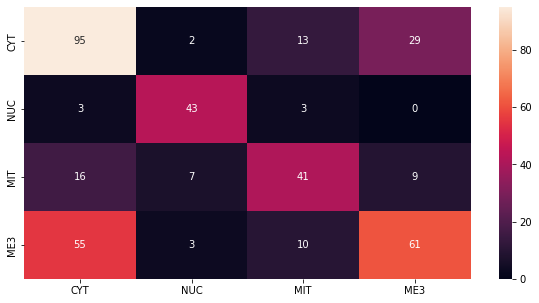

Exactitud en clasificación de clase CYT:  0.562
Exactitud en clasificación de clase NUC:  0.782
Exactitud en clasificación de clase MIT:  0.612
Exactitud en clasificación de clase ME3:  0.616


In [142]:
fig, ax = plt.subplots(figsize=(10,5))

predict = QDA.predict(x_test)
mat = confusion_matrix(y_test,predict)
sns.heatmap(mat,annot=True, fmt='d', ax=ax, xticklabels=['CYT', 'NUC', 'MIT', 'ME3'], yticklabels=['CYT', 'NUC', 'MIT', 'ME3'])
plt.show()

Acc_CYT = mat[0,0]/(sum(mat[:,0]))
Acc_NUC = mat[1,1]/(sum(mat[:,1]))
Acc_MIT = mat[2,2]/(sum(mat[:,2]))
Acc_ME3 = mat[3,3]/(sum(mat[:,3]))

print('Exactitud en clasificación de clase CYT: ', "%.3f" % Acc_CYT)
print('Exactitud en clasificación de clase NUC: ', "%.3f" % Acc_NUC)
print('Exactitud en clasificación de clase MIT: ', "%.3f" % Acc_MIT)
print('Exactitud en clasificación de clase ME3: ', "%.3f" % Acc_ME3)


**Como se mostró anteriormente, las métricas de micro y macro F1 score para el clasificador quedan:**

In [144]:
micro = f1_score(y_test, predict, average='micro')
macro = f1_score(y_test, predict, average='macro')

print('Micro F1 score en validación: ', "%.4f" % micro)
print('Macro F1 score en validación: ', "%.4f" % macro)

Micro F1 score en validación:  0.6154
Macro F1 score en validación:  0.6412


## Clasificación binaria

Para el problema de clasificación binaria se utilizarán las clases CYT y NUC. Esto no solo es debido a que son las clases más representativas sino porque al representar la ubicación de la proteína en el núcleo y en el citoplasma se convierten en una buena aproximación a la ubicación de la proteína "dentro del núcleo" y "fuera del núcleo", pudiendo ser esa clasificación relevante para algún análisis. Utilizaré todas las variables de entrada y un clasificador QDA.

In [122]:
data_bin = data_normalizada[data_normalizada['Class'].isin(['CYT', 'NUC'])]  #Me quedo con las clases que me interesan

X_binario = data_bin.drop(columns='Class').values
Y_binario = data_bin.Class.values


x_bin_train, x_bin_test, y_bin_train, y_bin_test = train_test_split(X_binario, Y_binario, random_state = 10, test_size=0.3, stratify=data_bin['Class'])

In [123]:
QDA_bin = QuadraticDiscriminantAnalysis()
QDA_bin.fit(x_bin_train,y_bin_train)

print('Exactitud en entrenamiento: ', "%.3f" % QDA_bin.score(x_bin_train,y_bin_train))
print('Exactitud en validación: ', "%.3f" % QDA_bin.score(x_bin_test,y_bin_test))

Exactitud en entrenamiento:  0.655
Exactitud en validación:  0.623


A continuación grafico la matriz de confusión del clasificador usando el set de testeo:

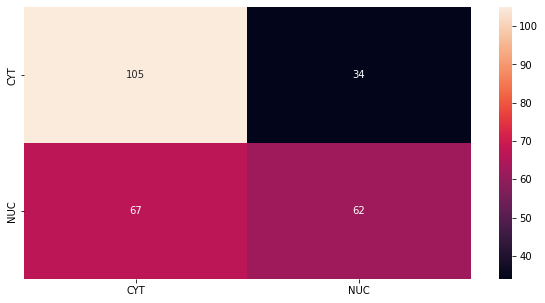

Exactitud en clasificación de clase CYT:  0.610
Exactitud en clasificación de clase NUC:  0.646


In [125]:
fig_bin, ax_bin = plt.subplots(figsize=(10,5))

predict_bin = QDA_bin.predict(x_bin_test)
mat_bin = confusion_matrix(y_bin_test,predict_bin)
sns.heatmap(mat_bin,annot=True, fmt='d', ax=ax_bin, xticklabels=['CYT', 'NUC'], yticklabels=['CYT', 'NUC'])
plt.show()

Acc_CYT_bin = mat_bin[0,0]/(sum(mat_bin[:,0]))
Acc_NUC_bin = mat_bin[1,1]/(sum(mat_bin[:,1]))


print('Exactitud en clasificación de clase CYT: ', "%.3f" % Acc_CYT_bin)
print('Exactitud en clasificación de clase NUC: ', "%.3f" % Acc_NUC_bin)


**Area debajo de la curva ROC:**

In [47]:
predict_bin_proba = QDA_bin.predict_proba(x_bin_test)
auc_roc = roc_auc_score(y_bin_test, predict_bin_proba[:,1])
print('El area bajo la curva ROC es: ', "%.4f" % auc_roc)

El area bajo la curva ROC es:  0.6977


Cabe aclarar que la elección del random_state afecta los resultados de las métricas de entrenamiento y validación, ya que para algunos valores del parámetro el mejor modelo era QDA y para otros regresión logística. Nuevamente, para evitar este tipo de variaciones es una buena idea usar validación cruzada.

# Dataset CASP

Se carga el dataset:

In [26]:
df_casp = pd.read_csv('CASP.csv', sep=',')
colnames = {'RMSD':'size_res','F1':'surface_area', 'F2':'npolar_exposed_area', 
            'F3':'frac_area_exposed_npolar_res', 'F4':'frac_area_exposed_npolar_part_res',
            'F5':'mass_w_exposed_area','F6':'avg_dev_exposed_area_res','F7':'euclidean_distance',
            'F8':'secondary_structure_penalty','F9':'distribution_constraints'}

df_casp.rename(columns=colnames, inplace=True)
df_casp.head()

,size_res,surface_area,npolar_exposed_area,frac_area_exposed_npolar_res,frac_area_exposed_npolar_part_res,mass_w_exposed_area,avg_dev_exposed_area_res,euclidean_distance,secondary_structure_penalty,distribution_constraints
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


Analizo las correlaciones entre las variables de entrada

In [27]:
CASP_corr = pd.DataFrame(np.corrcoef(df_casp, rowvar=False))
CASP_corr.columns = df_casp.columns
CASP_corr.index = df_casp.columns
CASP_corr

,size_res,surface_area,npolar_exposed_area,frac_area_exposed_npolar_res,frac_area_exposed_npolar_part_res,mass_w_exposed_area,avg_dev_exposed_area_res,euclidean_distance,secondary_structure_penalty,distribution_constraints
size_res,1.000000,-0.015087,0.156895,0.374309,-0.169771,-0.013982,-0.036135,-0.003339,0.000344,0.062830
surface_area,-0.015087,1.000000,0.906606,0.126285,0.931056,0.998185,0.967531,0.554002,0.651251,-0.898240
npolar_exposed_area,0.156895,0.906606,1.000000,0.502562,0.793143,0.902853,0.908354,0.515929,0.584242,-0.786188
frac_area_exposed_npolar_res,0.374309,0.126285,0.502562,1.000000,0.031230,0.122622,0.200650,0.080064,0.095340,-0.069039
frac_area_exposed_npolar_part_res,-0.169771,0.931056,0.793143,0.031230,1.000000,0.925707,0.938108,0.485185,0.676919,-0.891766
mass_w_exposed_area,-0.013982,0.998185,0.902853,0.122622,0.925707,1.000000,0.961769,0.553729,0.642961,-0.897765
avg_dev_exposed_area_res,-0.036135,0.967531,0.908354,0.200650,0.938108,0.961769,1.000000,0.538198,0.662584,-0.881973
euclidean_distance,-0.003339,0.554002,0.515929,0.080064,0.485185,0.553729,0.538198,1.000000,0.347030,-0.521148
secondary_structure_penalty,0.000344,0.651251,0.584242,0.095340,0.676919,0.642961,0.662584,0.347030,1.000000,-0.637287
distribution_constraints,0.062830,-0.898240,-0.786188,-0.069039,-0.891766,-0.897765,-0.881973,-0.521148,-0.637287,1.000000


Como se ve, algunas variables presentan alta correlación con otras, incluso habiendo algunas muy correlacionadas con multiples variables. Esto podría significar, quizás, que se puede reducir el número de variables de entrada al modelo. Se realizará esta reducción luego con PCA y se comparará los resultados contra el caso sin reducción de variables.

## Regresión lineal

Sin reducción de variables:

In [28]:
X_casp = df_casp.drop(columns='size_res').values
Y_casp = df_casp.size_res.values

normalizador = StandardScaler()
X_casp = normalizador.fit_transform(X_casp)   #Normalizo los datos de entrada


Xcasp_train, Xcasp_test, Ycasp_train, Ycasp_test = train_test_split(X_casp, Y_casp, test_size=0.3, random_state=0)

regresor_lineal = LinearRegression()
regresor_lineal.fit(Xcasp_train,Ycasp_train)

r2 = regresor_lineal.score(Xcasp_test,Ycasp_test)
print('El valor R\u00b2 del regresor lineal es: ', "%.3f" % r2)

El valor R² del regresor lineal es:  0.278


Realizando una reducción de variables con Principal Component Annalysis (PCA):

In [58]:
pca = PCA(n_components=5)
xcasp_pca = pca.fit_transform(X_casp)

xcasp_pca_train, xcasp_pca_test, ycasp_pca_train, ycasp_pca_test = train_test_split(xcasp_pca, Y_casp, random_state = 0, test_size=0.3)

regresor_lineal_pca = LinearRegression()
regresor_lineal_pca.fit(xcasp_pca_train,ycasp_pca_train)
r2pca = regresor_lineal_pca.score(xcasp_pca_test,ycasp_pca_test)
print('El valor R\u00b2 del regresor lineal con PCA de 4 vectores es: ', "%.3f" % r2pca)

El valor R² del regresor lineal con PCA de 4 vectores es:  0.171


Disminuyendo el número de componentes en cualquier cantidad se consigue un resultado igual o peor que usando todas las variables. Reducir el número de entradas no brinda mejores resultados, a continuación se prueba aumentando el número con una extensión polinomial.

Extensión polinomial de segundo, tercer y cuarto grado:

In [76]:
scores = []
MSE = []
for i in range (2,5):
    poly_casp = PolynomialFeatures(i)
    Xcasp_poly_train = poly_casp.fit_transform(Xcasp_train)
    Xcasp_poly_test = poly_casp.transform(Xcasp_test)

    regresor_lineal_poly = LinearRegression()
    regresor_lineal_poly.fit(Xcasp_poly_train,Ycasp_train)
    r2poly = regresor_lineal_poly.score(Xcasp_poly_test,Ycasp_test)
    
    y_casp_pred = regresor_lineal_poly.predict(Xcasp_poly_test)
    mse = mean_squared_error(Ycasp_test,y_casp_pred)
    scores.append(r2poly)
    MSE.append(mse)
    print('El valor R\u00b2 del regresor lineal con extensión polinomial de orden %d es: ' % i, "%.3f" % r2poly)

El valor R² del regresor lineal con extensión polinomial de orden 2 es:  0.369
El valor R² del regresor lineal con extensión polinomial de orden 3 es:  0.406
El valor R² del regresor lineal con extensión polinomial de orden 4 es:  -22.613


La extensión polinomial de grado 3 da los mejores resultados entre todas las extensiones polinomiales. 

Se intentó también realizar una combinación entre PCA y extensión polinomial de los componentes, es decir obtener una reducción en los componentes principales y luego extenderlos polinomialmente, pero se obtuvo un valor de R^2 menor que únicamente realizando extensión polinomial.

**Los MSE de los regresores son:**

In [83]:
print('El valor MSE del regresor lineal con extensión polinomial de orden %d es: ' % 2, "%.3f" % MSE[0])
print('El valor MSE del regresor lineal con extensión polinomial de orden %d es: ' % 3, "%.3f" % MSE[1])
print('El valor MSE del regresor lineal con extensión polinomial de orden %d es: ' % 4, "%.3f" % MSE[2])

El valor MSE del regresor lineal con extensión polinomial de orden 2 es:  23.528
El valor MSE del regresor lineal con extensión polinomial de orden 3 es:  22.155
El valor MSE del regresor lineal con extensión polinomial de orden 4 es:  880.143


El error cuadrático medio es menor en el regresor polinomial de tercer orden, estando muy cerca el de segundo orden.